# Distance: Flying Experiments

Detect the distance to the wall while flying and playing sweeps.

In [1]:
import math
import sys

import IPython
import IPython.display as ipd
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

%matplotlib inline
#%matplotlib notebook

from matplotlib import rcParams

rcParams["figure.max_open_warning"] = False
rcParams["font.family"] = 'DejaVu Sans'
rcParams["font.size"] = 12

In [2]:
def get_calib_function(calib="stepper"):
    from utils.calibration import get_calibration_function_median
    from utils.calibration import get_calibration_function_moving
    
    if calib == "manual":
        print("using manual")
        calib_function_median, freqs = get_calibration_function_moving(
            "2021_07_27_manual", motors="all45000", fit_one_gain=False
        )
    elif calib == "flying":
        print("using flying")
        calib_function_median, freqs = get_calibration_function_moving(
            "2021_10_12_flying", motors="linear_buzzer_cont", fit_one_gain=False,
            #"2021_07_14_flying", motors="linear_buzzer_cont", fit_one_gain=False,
            appendix_list=["_new3", "_new4", "_new6"], 
        )
    elif calib == "hover":
        print("using hovering")
        calib_function_median, freqs = get_calibration_function_moving(
            #"2021_07_27_hover", 
            "2021_10_12_hover", 
            motors="hover_sweep", fit_one_gain=False,
            #appendix_list=["_30", "_50"]
        )
    elif calib == "stepper":
        print("using stepper dataset")
        calib_function_median, freqs = get_calibration_function_median(
            #"2021_07_08_stepper_fast",
            "2021_10_07_stepper_new_f",
            motors="all45000",
            mic_type="audio_deck",
            snr=5,
            fit_one_gain=False,
        )
    elif calib == "stepper_nomotors":
        print("using stepper dataset without motors")
        calib_function_median, freqs = get_calibration_function_median(
            #"2021_07_08_stepper_fast",
            "2021_10_07_stepper_new_f",
            motors=0,
            mic_type="audio_deck",
            snr=5,
            fit_one_gain=False,
        )
    else:
        raise ValueError(calib)
    return calib_function_median

In [3]:
def plot_positions(ax, positions_cm):
    from matplotlib import cm
    
    cmap = cm.get_cmap('inferno') 
    n_labels = 3
    label = None
    step = len(positions_cm) // n_labels
    for i, p in enumerate(positions_cm):
        if i % step == 0 or (i == len(positions_cm) - 1):
            label = f'position {i}'
        ax.scatter(*p[:2], color=cmap(i / len(positions_cm)), label=label)
        label=None
    ax.plot(positions_cm[:, 0], positions_cm[:, 1], color='k', ls=':')
    ax.axis('equal')
    ax.set_xlabel('x [cm]')
    ax.set_ylabel('y [cm]')
    ax.axhline(y=0, color='k', label='wall')
    ax.grid()
    ax.legend()

In [4]:
def get_positions_flying(row, start_distance_cm):
    #start = row.positions[2, :3] * 1e2
    #print('starting positions:', row.positions[:5, :3])
    start = [0, 0]
    positions_cm = np.c_[
        start[0] - (row.positions[:, 0] * 1e2),
        start[1] - (row.positions[:, 1] * 1e2) + start_distance_cm ,
        row.positions[:, 2] * 1e2
    ]
    #print('new starting position:', positions_cm[0, :])
    #print('new ending position:', positions_cm[-1, :])
    return positions_cm, row.positions[:, 3]

In [5]:
def extract_valid(row):
    positions_cm, yaws_deg = get_positions_flying(row, start_distance_cm=95)
    freqs = row.frequencies_matrix[0, :]
    
    print('starting frequencies', row.frequencies_matrix[:, 0])
    values = np.abs(row.stft)[..., freqs>0] # n_times x n_mics x freqs
    distances = positions_cm[:, 1]
    freqs_valid = freqs[freqs>0]
    
    forward_indices = np.ones(len(distances), dtype=bool)
    #print("all", len(distances))
    forward_indices[1:] &= (distances[1:] - distances[:-1] <= 0)
    print("forward:", np.sum(forward_indices))
    forward_indices &= positions_cm[:, 2] > 30
    #print(forward_indices)
    #print("flying:", np.sum(forward_indices))
    means = np.sum(np.mean(values, axis=-1), axis=-1)
    crashs = np.where((means - np.mean(means)) > (2 * np.std(means)))[0]
    if len(crashs):
        print('crashs found:', crashs)
        forward_indices[crashs[0]:] = 0
    else:
        print('no crashs found')
        pass
    
    values = values[forward_indices, :]
    distances = distances[forward_indices]
    positions_cm = positions_cm[forward_indices, :]
    yaws_deg = yaws_deg[forward_indices]

    #sort_idx = np.argsort(distances)
    #distances = distances[sort_idx]
    #values_sorted = values[sort_idx, ...]
    return distances, freqs_valid, values, positions_cm, yaws_deg

In [6]:
def plot_matrix(dists_cm, results_matrix, d_estimates, no_deco=False):
    fig, ax = plt.subplots()
    fig.set_size_inches(2 * FIGSIZE, FIGSIZE)
    im = pcolorfast_custom(
        ax,
        np.arange(n_points),
        dists_cm,
        np.log10(results_matrix),
        vmin=-3,
    )
    ax.plot(
        np.arange(n_points) + 0.5,
        xvalues,
        color="white",
        label="ground truth",
        marker='x'
    )
    ax.set_ylim(min(dists_cm), max(dists_cm))
    ax.plot(
        np.arange(n_points) + 0.5,
        d_estimates,
        color="white",
        label="estimates",
        marker='o',
        ls='-'
    )
    if not no_deco:
        add_colorbar(fig, ax, im, title="log-probability")
        ax.set_ylabel("estimated distance [cm]")
        ax.set_xlabel("real distance [cm]")
        #ax.set_title(f"appendix{appendix}, {n_points} measurements")
        leg = ax.legend(framealpha=0, loc='upper right')
        for text in leg.get_texts():
            plt.setp(text, color='w')
        ax.set_xticklabels(np.round(xvalues, 1), rotation=90)
        ax.set_yticks(np.arange(min(dists_cm), max(dists_cm), step=10))
        ax.set_yticklabels(np.arange(min(dists_cm), max(dists_cm), step=10).astype(int))
    else:
        ax.set_yticks([])
        ax.set_xticks([])
    return fig, ax

def get_estimates(results_matrix, dists_cm):
    valid = np.any(results_matrix > 0, axis=0)
    d_estimates = dists_cm[np.argmax(results_matrix, axis=0)]
    d_estimates[~valid] = np.nan
    return d_estimates

starting frequencies [3046. 3046. 3046. 3046. 3046. 3046. 3046. 3046. 3046. 3046. 3046. 3046.
 3046. 3046. 3046. 3046. 3046. 3046. 3046. 3046. 3046. 3046. 3046. 3046.
 3046. 3046. 3046. 3046. 3046. 3046. 3046. 3046.]
forward: 20
no crashs found


/home/duembgen/Virtualenvs/Audio/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


saved as plots/experiments/2021_10_12_flying_new3_on_the_fly.pdf
saved as plots/experiments/2021_10_12_flying_new3_positions.pdf


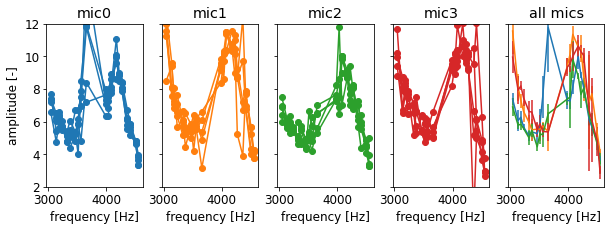

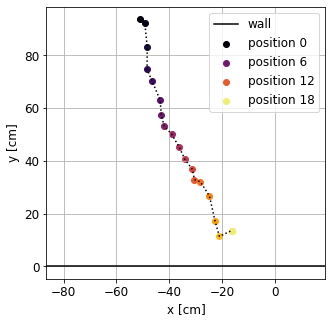

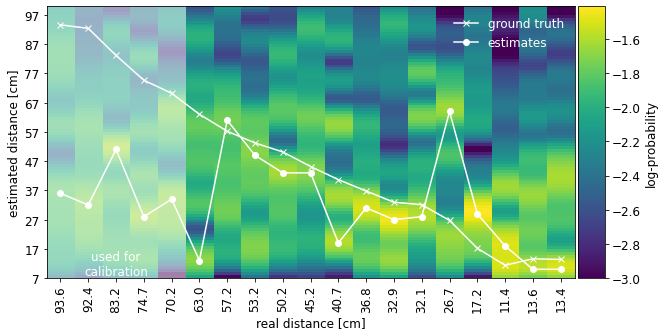

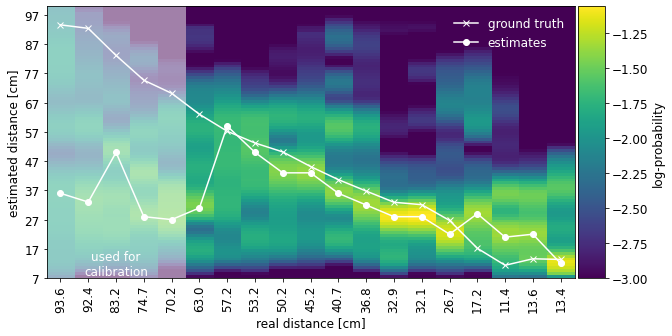

In [23]:
from copy import deepcopy
import itertools
import time
from matplotlib.patches import Rectangle

from crazyflie_description_py.experiments import WALL_ANGLE_DEG
from utils.plotting_tools import pcolorfast_custom, FIGSIZE, save_fig
from utils.plotting_tools import add_colorbar
from utils.plotting_tools import plot_performance
from utils.inference import Inference, eps_normalize
from utils.estimators import DistanceEstimator
from utils.moving_estimators import MovingEstimator

def add_rect(ax, width, height, no_deco=False):
    rect = Rectangle((0, 0), width, height, facecolor='white', alpha=0.5)
    ax.add_patch(rect)
    if not no_deco:
        ax.text(width/2, 7, "used for\ncalibration", fontdict={'color':'white', 'ha':'center', 'va':'bottom'})

azimuth_deg = WALL_ANGLE_DEG
n_calib = 5
n_window = 3
bad_freqs = []
#bad_freqs = [[3500, 3900]]

plot_dict = [
    #{"exp_name": "2021_11_23_demo", "motors": "live", "appendix": "hover5"},
    {"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_new3"},
    #{"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_new4"},
    #{"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_new6"},
    #{"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_new7"},
    #{"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_new8"},
    #{"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_new10"},
    #{"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_new12"},
    #{"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_1"},
    #{"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_2"},
    #{"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_3"},
    #{"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_4"},
    #{"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_5"},
    #{"exp_name": "2021_10_12_flying", "motors": "linear_buzzer_cont", "appendix": "_6"},
]

errors_df = pd.DataFrame(
    columns=["algorithm", "mics", "calib_method", "estimates", "distances", "appendix", "time"]
)

calib_method_list = ["on_the_fly"] 
#calib_method_list = ["stepper"]
# mic_list = [[0], [1], [2], [3]]
mic_list = [[0, 1, 2, 3]] #[[1, 3], [0, 2], [0, 1, 3], [0, 1, 2, 3]]
algorithm_list = ["bayes"]#, "cost"]
no_deco = False

calib_flag = False
for params in plot_dict:
    exp_name, motors, appendix = params.values()

    results_df = pd.read_pickle(f"../datasets/{exp_name}/all_data.pkl")
    row = results_df.loc[
        (results_df.appendix == appendix) & (results_df.motors == motors), :
    ].iloc[0]
    xvalues, yvalues, values_unsorted, positions_cm, yaws_deg = extract_valid(row)
    n_points = values_unsorted.shape[0]
    
    if not calib_flag:
        calib_on_the_fly = np.median(values_unsorted[:n_calib, :, :], axis=0)
        calib_flag = True
    #print("calibration:", values_unsorted[:n_calib, :, :])
    std_values = np.std(values_unsorted[:n_calib, :, :], axis=0)

    plot_name_calib = f"plots/experiments/{exp_name}{appendix}_on_the_fly.pdf"
    fig_calib, axs_calib = plt.subplots(1, 5, sharey=True)
    fig_calib.set_size_inches(10, 3)
    axs_calib[0].set_ylabel(f"amplitude [-]")
    for m in range(4):
        axs_calib[m].plot(yvalues, values_unsorted[:n_calib, m, :].T, color=f"C{m}", marker='o')
        axs_calib[m].set_title(f"mic{m}")
        axs_calib[4].errorbar(yvalues, calib_on_the_fly[m], std_values[m], label=f"mic{m}")
        axs_calib[m].set_xlabel(f"frequency [Hz]")
    axs_calib[4].set_xlabel(f"frequency [Hz]")
    axs_calib[4].set_title(f"all mics")
    axs_calib[0].set_ylim(2, 12)
    [axs_calib[0].axvline(f, color='black') for fs in bad_freqs for f in fs]
    save_fig(fig_calib, plot_name_calib)

    # values = np.random.rand(len(yvalues))
    # yvalues_grid, values_grid = interpolate_parts(yvalues, values)
    # fig = plt.figure()
    # fig.set_size_inches(10, 5)
    # plt.plot(yvalues, values, marker='+', label='original')
    # plt.plot(yvalues_grid, values_grid, marker='+', label='interpolated')
    # plt.legend()
    # break

    fig, ax = plt.subplots()
    fig.set_size_inches(FIGSIZE, FIGSIZE)
    plot_positions(ax, positions_cm)
    plot_name = f"plots/experiments/{exp_name}{appendix}_positions.pdf"
    save_fig(fig, plot_name)

    inf_machine = Inference()
    dists_cm = DistanceEstimator.DISTANCES_M * 1e2
    inf_machine.add_geometry([dists_cm[0], dists_cm[-1]], WALL_ANGLE_DEG)

    for calib_method in calib_method_list:
        if calib_method == "on_the_fly":
            # calib_function = get_calib_function("stepper")
            # will be overwritten
            calib_values = calib_on_the_fly
        else:
            calib_function = get_calib_function(calib_method)
            calib_values = calib_function(yvalues)
        values_unsorted_calib = values_unsorted / calib_values

        for mics, algorithm in itertools.product(mic_list, algorithm_list):
            mics_str = str(mics).replace(" ", "")
            plot_name = f"plots/experiments/{exp_name}{appendix}_{algorithm}_{calib_method}_{mics_str}"

            results_matrix = np.full((len(dists_cm), n_points), np.nan)
            results_matrix_moving = np.full((len(dists_cm), n_points), np.nan)

            moving_estimator = MovingEstimator(n_window=n_window)
            
            time_moving = 0
            time_single = 0
            for i in range(n_points):
                
                #print("magnitudes", values_unsorted[i])
                #print("calib magnitudes", values_unsorted_calib[i])

                #if (calib_method == "on_the_fly") and (i < n_calib):
                #    continue

                # important to reinitialize!
                distance_estimator = DistanceEstimator()

                # inf_machine.add_data(values_theo[:, :, i], yvalues_theo)
                
                # TODO(FD) figure out if below helps
                #if i < (n_points - 1):
                #    rel_dist = xvalues[i+1] - xvalues[i]
                #else:
                rel_dist = 5
                inf_machine.add_data(
                    values_unsorted_calib[i],
                    yvalues,
                    distances=-np.linspace(0, rel_dist, len(yvalues)),
                )
                
                # TODO(FD) check again if this helps...
                inf_machine.filter_out_freqs(freq_ranges=bad_freqs)
                
                t1 = time.time()
                for mic_idx in mics:
                    dist, prob_mic, diff = inf_machine.do_inference(algorithm, mic_idx)
                    distance_estimator.add_distribution(diff * 1e-2, prob_mic, mic_idx)

                d_m, prob = distance_estimator.get_distance_distribution(
                    distances_m=dists_cm * 1e-2, verbose=False, azimuth_deg=azimuth_deg,
                )
                np.testing.assert_allclose(d_m*1e2, dists_cm)
                time_single += int(1000*(time.time() - t1))

                # TODO(FD): maybe remove requirement to have angle distribution
                #d_est_m = d_m[np.argmax(prob)]
                #angle, prob_angle = distance_estimator.get_angle_distribution(
                #    distance_estimate_m=d_est_m
                #)

                t1 = time.time()
                moving_estimator.add_distributions(
                    dist_cm=dists_cm, dist_p=prob, position_cm=positions_cm[i], rot_deg=yaws_deg[i]
                )
                test_cm, prob_moving = moving_estimator.get_distance_distribution(
                    distances_cm=dists_cm
                )
                np.testing.assert_allclose(test_cm, dists_cm)
                time_moving += int(1000*(time.time() - t1))
                
                results_matrix_moving[:, i] = prob_moving 
                results_matrix[:, i] = prob

            d_estimates = get_estimates(results_matrix, dists_cm)
            errors_df.loc[len(errors_df), :] = {
                "algorithm": algorithm,
                "mics": mics_str,
                "calib_method": calib_method,
                "estimates": d_estimates,
                "distances": xvalues,
                "appendix": appendix,
                "time": time_single / n_points 
            }
            fig, ax = plot_matrix(dists_cm, results_matrix, d_estimates, no_deco=no_deco)
            if calib_method == 'on_the_fly':
                add_rect(ax, n_calib, max(dists_cm), no_deco=no_deco)
            #save_fig(fig, plot_name + "_probabilities.pdf")

            d_estimates_moving = get_estimates(results_matrix_moving, dists_cm)
            errors_df.loc[len(errors_df), :] = {
                "algorithm": algorithm + f"_win{n_window}",
                "mics": mics_str,
                "calib_method": calib_method,
                "estimates": d_estimates_moving,
                "distances": xvalues,
                "appendix": appendix,
                "time": time_moving / n_points 
            }
            fig, ax = plot_matrix(dists_cm, results_matrix_moving, d_estimates_moving, no_deco=no_deco)
            if calib_method == 'on_the_fly':
                add_rect(ax, n_calib, max(dists_cm), no_deco=no_deco)
            #save_fig(fig, plot_name + f"_win{n_window}_probabilities.pdf")

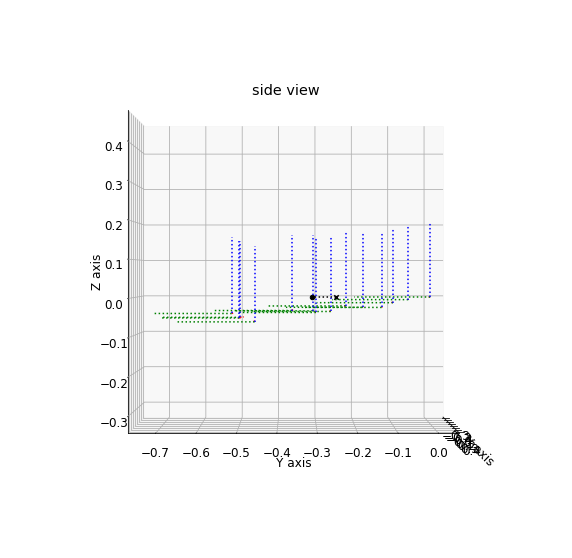

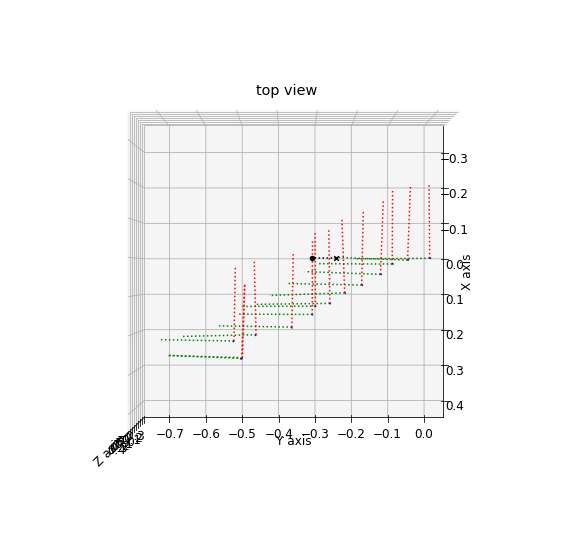

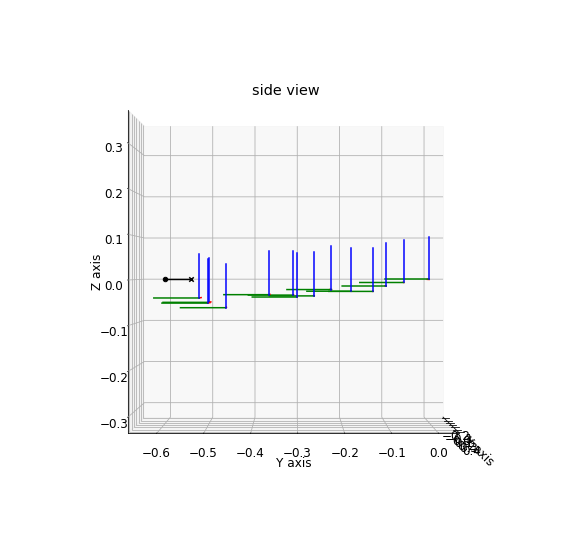

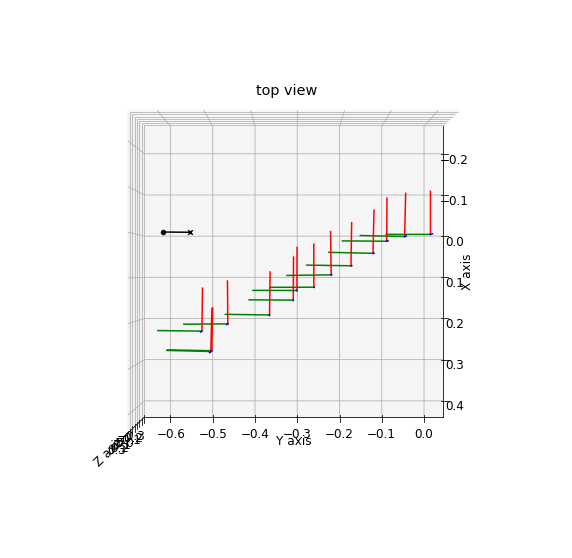

In [10]:
from factor_graph.plot import plot_projections
import gtsam
from audio_gtsam.wall_backend import WallBackend

wall_backend = WallBackend()
yaw_start = np.pi

use_groundtruth = False

for i, prob_dists in enumerate(results_matrix_moving.T):
    if i < n_calib:
        #print("skipping cause calibrating:", i)
        continue
    
    position_cm = positions_cm[i, :] - positions_cm[n_calib, :]
    yaw_deg = yaws_deg[i]
    #print("yaw:", round(yaw_deg))
    
    pose_factor = wall_backend.add_pose(r_world=position_cm * 1e-2, 
                                        yaw=yaw_start + (yaw_deg / 180 * np.pi))
    
    distance_gt = int(60 + position_cm[1])
    #print("ground truth distance", distance_gt)
    if use_groundtruth:
        dists_cm = np.arange(100)
        prob_dists = np.zeros(100)
        prob_dists[distance_gt] = 1.0
    try:
        wall_backend.add_planes_from_distance_distribution(dists_cm, prob_dists, azimuth_deg=-90, n_estimates=1, verbose=False)
    except Exception as e:
        print(e)
wall_backend.get_results()
plot_projections(wall_backend.all_initial_estimates, axis_length=0.2, ls=":", perspective=False, side=True)
plt.show()
plot_projections(wall_backend.result, axis_length=0.1, perspective=False, side=True)
plt.show()

In [ ]:
def plot_random(axs, dists):
    np.random.seed(1)
    errors_rand = []
    for d in dists:
        d_rand = np.random.choice(range(7, 100))
        errors_rand.append(d_rand - d)
    axs[0].plot(dists, errors_rand, color='k', label='random', ls='', marker='x', markersize=2)
    axs[1].plot(sorted(np.abs(errors_rand)), np.linspace(0, 1, len(errors_rand)), color='k', ls='', label='random', marker='x', markersize=2)
    axs[1].legend(loc='lower right')

In [ ]:
from utils.plotting_tools import plot_performance, save_fig

#exp_name = '2021_10_12_flying'

fname = f'../datasets/{exp_name}/results.pkl'
errors_df = pd.read_pickle(fname)

chosen_mics = '[0,1,2,3]'

filtered_df = errors_df.loc[errors_df.mics==chosen_mics]
groupby = ['mics', 'algorithm']

total_err_dict = {}
for j, (labels, df) in enumerate(filtered_df.groupby(groupby, sort=False)):
    params = dict(zip(groupby, labels))
        
    err_dict = {}
    dist_dict = {}
    errors_all = []
    distances_all = []
    for i, row in df.iterrows():
        errors = row.estimates - row.distances
        key = ' '.join(row.drop(['distances', 'estimates', 'time'] + groupby).values)
        err_dict[key] = errors
        dist_dict[key] = row.distances
        errors_all += list(errors[~np.isnan(errors)])
        distances_all += list(row.distances[~np.isnan(errors)])
        
    sort_idx = np.argsort(distances_all)
    total_err_dict[j] = {
        'errors': np.array(errors_all)[sort_idx],
        'distances': np.array(distances_all)[sort_idx],
        **params
    }
    
    title = ''
    for k,l in params.items():
        title = f"{title} {k}: {l}"

    fig, axs = plot_performance(err_dict, xs_dict=dist_dict, xlabel="distance [cm]", ylabel="error [cm]")
    plot_random(axs, range(10, 80))
    #fig, axs = plot_performance(err_dict, xlabel="distance [cm]", ylabel="error [cm]")
    fig.suptitle(title)
    axs[0].get_legend().set_visible(False)
    axs[0].set_ylim(-60, 60)
    axs[1].set_xlim(-2, 60)
    save_fig(fig, f'plots/experiments/{exp_name}_{chosen_mics}_{params["algorithm"]}_cdf.pdf')

In [ ]:
max_dist = 40
err_dict = {}
dist_dict = {}
for total_dict in total_err_dict.values():
    key = total_dict['algorithm']
    errors = total_dict['errors']
    dists = total_dict['distances']
    err_dict[key] = errors[dists < 40]
    dist_dict[key] = dists[dists < 40]
    
fig, axs = plot_performance(err_dict, xs_dict=dist_dict, xlabel="distance [cm]", ylabel="error [cm]", marker_flag=False)
axs[0].get_legend().set_visible(False)
plot_random(axs, range(10, max_dist))
fig.suptitle(f'overall performacne mics {chosen_mics} up to {max_dist}cm')
save_fig(fig, f'plots/experiments/{exp_name}_{chosen_mics}_cdf.pdf')

# WIP: flying experiments with timestamps for each amplitude (snr=3)

In [ ]:
MIN_Z_CM = 30 # minimum flying height

def plot_plositions(row, min_time=None, max_time=None, max_dist=None):
    import seaborn as sns
    positions_cm = row.positions[:, :3] * 100
    fig, axs = plt.subplots(1, 3) 
    fig.set_size_inches(10, 3.3)
    fig.suptitle(row.appendix, y=1.0)
    
    mask_time = np.ones_like(row.seconds, dtype=np.bool)
    if min_time is not None:
        mask_time = (row.seconds > min_time) 
    else:
        mask_time = positions_cm[:, 2] > MIN_Z_CM
    if max_time is not None:
        mask_time = mask_time & (row.seconds < max_time)
    else:
        mask_time = positions_cm[:, 2] > MIN_Z_CM
        
    time = row.seconds[mask_time]
    
    #axs[0].plot(x=positions_cm[:, 0], y=positions_cm[:, 1], color=colors())
    sns.scatterplot(x=positions_cm[mask_time, 0], y=positions_cm[mask_time, 1], 
                    hue=time, ax=axs[0], linewidth=0, 
                    #size=positions_cm[:, 2],
                    palette='inferno')
    axs[0].set_xlabel('x [cm]')
    axs[0].set_ylabel('y [cm]')
    axs[0].axis('equal')
    axs[0].legend(loc='lower right', title='time [s]')

    axs[1].plot(time, positions_cm[mask_time, 0], label='x')
    axs[1].plot(time, positions_cm[mask_time, 1], label='y')
    axs[1].plot(time, positions_cm[mask_time, 2], label='z')
    axs[1].set_xlabel('time [s]')
    axs[1].set_ylabel('movement [cm]')
    if max_dist is not None:
        axs[1].set_ylim(-max_dist, max_dist)
    axs[1].legend(loc='lower right')

    axs[2].plot(time, row.positions[mask_time, 3], label='yaw')
    axs[2].set_ylabel('yaw [deg]')
    axs[2].set_xlabel('time [s]')
    axs[2].set_ylim(-20, 20)
    axs[2].legend(loc='lower right')
    plt.tight_layout()
    return fig, axs

def plot_audio(row, mic_idx=0):
    from utils.plotting_tools import pcolorfast_custom
    all_frequencies = row.freqs
    spec = row.spectrogram[:, mic_idx, :]
    spec[spec == 0] = np.nan
    total = np.nanmean(np.abs(spec), axis=1)
    
    label = str(f"{row.appendix}").replace('_', '')
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    ax.set_title(f'spectrogram of mic{mic_idx}, appendix {row.appendix}')
    
    # mark too long measurements gray
    max_diff = 1
    diff = row.seconds[1:] - row.seconds[:-1]
    indices = np.where(diff>max_diff)[0]
    endings = row.seconds[:-1][indices]
    diff_average = np.mean(diff[diff<max_diff])
    seconds = row.seconds
    for counter, i in enumerate(indices):
        new_time = seconds[i+counter]+diff_average
        seconds = np.insert(seconds, i+counter+1, new_time)
        spec = np.insert(spec, i+counter+1, np.nan, axis=1)
    
    pcolorfast_custom(ax, seconds, all_frequencies, np.abs(spec))
    
    xticks = np.arange(0, row.seconds.max(), step=5)
    ax.set_xticks(xticks); ax.set_xticklabels(xticks)
    yticks = np.arange((np.round(row.freqs.min()//1000)+1)*1000, 
                        row.freqs.max(), step=1000)
    ax.set_yticks(yticks); ax.set_yticklabels(yticks)
    ax.set_ylabel('frequency [Hz]')
    ax.set_xlabel('seconds [s]')
    return fig, ax

linestyles = {"estimated": "-", "theo": ":", "theo_corr": "-.", "measured": "-"}
colors = {"estimated": "C0", "theo": "black", "theo_corr": "black", "measured":"C0"}
keys = {"estimated": "estimated", "theo": "theo, vertical", "theo_corr": "theoretical", "measured":"measured"}


def change_order(axs_all, mean_distances, xlabel="distance", unit="cm", ylabel="probability [-]", title=True):
    sorted_idx = np.argsort(mean_distances)
    positions = [ax.get_position() for ax in axs_all]
    for i, idx in enumerate(sorted_idx):
        axs_all[idx].set_position(positions[i])
        if title:
            axs_all[idx].set_title(f"{mean_distances[idx]:.0f}{unit}")
    [ax.get_yaxis().set_visible(False) for ax in axs_all[sorted_idx[1:]]]
    axs_all[sorted_idx[len(sorted_idx)//2]].set_xlabel(f"{xlabel} [{unit}]")
    axs_all[sorted_idx[0]].set_ylabel(ylabel)
    axs_all[sorted_idx[-1]].legend(loc="upper left", bbox_to_anchor=[1.0, 1.0])
    return axs_all

In [ ]:
exp_name = '2021_05_04_flying'; # snr = 3
fname = f'../datasets/{exp_name}/all_data.pkl'

try:
    df_total = pd.read_pickle(fname)
    print('read', fname)
except:
    answer = input('Run csv_or_wav_parser.py to parse experiments? (y/[n])') or 'n'
    if answer == 'y':
        df_total = parse_experiments(exp_name)
        pd.to_pickle(df_total, fname)
        print('saved', fname)

df_total.sort_values(by='appendix', inplace=True)

from utils.geometry import Context
context = Context.get_crazyflie_setup(dim=2)
fig, ax = plt.subplots()
context.plot(ax=ax)
fig.set_size_inches(3, 3)


min_time = None #4 #None
max_time = None #14 #None
max_dist = None

#starting_distance = 65.63 # 42+29.7−6.07 
starting_distance = 100

fig_total, ax_total = plt.subplots()
fig_total.set_size_inches(3, 3)
for i, row in df_total.iterrows():
    fig, axs = plot_plositions(row, min_time, max_time, max_dist)
    
    x = row.positions[:, 0] * 100
    y = row.positions[:, 1] * 100 - starting_distance
    z = row.positions[:, 2] * 100
    
    x = x[~np.isnan(x)] 
    y = y[~np.isnan(y)]
    
    x = x[z[~np.isnan(z)] > MIN_Z_CM]
    y = y[z[~np.isnan(z)] > MIN_Z_CM]
    
    #ax_total.scatter(x, y, s=10.0, label=row.appendix)
    ax_total.plot(x, y, marker='o', label=row.appendix.replace('_', ''))
    #mask2 = (y > -130) & (y < -100)
    #mask3 = (y > -100) & (y < -70)
    #mask4 = (y > -70)
    #for mask in [mask2, mask3, mask4]:
    #    ax_total.scatter(x[mask], y[mask], s=10.0)
    #save_fig(fig, f'plots/experiments/{exp_name}{row.appendix}_movement', extension='.png')
ax_total.axis('equal')
ax_total.set_xlabel('x [cm]')
ax_total.set_ylabel('y [cm]')
ax_total.axhline(0, color='k', label='wall')
ax_total.legend(bbox_to_anchor=[1.0, 1.0], loc='upper left')
#save_fig(fig_total, f'plots/experiments/{exp_name}_pos.png')

In [ ]:
## audio analysis

from utils.frequency_analysis import add_spectrogram

df_total = df_total.assign(spectrogram=None,freqs=None)
df_total = df_total.apply(add_spectrogram, axis=1)
print(df_total.columns)

mic_idx = 0

#maxi = np.nanmax(np.concatenate([*dfs.spectrogram], axis=1))
for i_col, row in df_total.iterrows():
    
    #complicated spectrogram
    fig, ax = plot_audio(row, mic_idx=mic_idx)
    #ax.set_ylim([2800, 5000])
    #save_fig(fig, f'plots/experiments/{exp_name}{row.appendix}_spec')
    
    #if not row.appendix in ["_bin5_thirdtry", "_bin6"]:
    #    continue
    #fig, ax = plt.subplots()
    #ax.pcolorfast(row.seconds, row.freqs, np.log10(np.abs(row.spectrogram[:-1, mic_idx, :-1])))
    #ax.set_title(row.appendix)

In [ ]:
## algorithm performance

from utils.calibration import get_calibration_function_median
from utils.inference import Inference

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
calib_function, calib_freq = get_calibration_function_median(
    "2021_04_30_stepper", "audio_deck", ax=ax, snr=3, motors=0#fit_one_gain=True 
)
inf_machine = Inference()
inf_machine.add_calibration_function(calib_function)


from utils.dataset_parameters import kwargs_datasets
from crazyflie_description_py.experiments import WALL_ANGLE_DEG

kwargs = kwargs_datasets[exp_name]["audio_deck"]
azimuth_deg = WALL_ANGLE_DEG

distance_range = [7, 50]
freq_range = [3000, 5000]

fig_df, ax_df = plot_df(distance_range, azimuth_deg=azimuth_deg)

inf_machine.add_geometry(distance_range, azimuth_deg)

In [ ]:
from copy import deepcopy
from itertools import cycle

from utils.data_collector import DataCollector
from utils.estimators import DistanceEstimator, get_estimate
from utils.inference import eps_normalize
from utils.simulation import get_freq_slice_theory

eps = 1e-5  # for plotting only
max_plot_distance = 110
algorithm = "bayes"
# algorithm = "cost"
normalize = True  # normalize probas before combining
method = "sum"  # method used to combine

nominal_ds = [60, 40, 20]

freqs_calib = np.linspace(
    np.min(row.frequencies_matrix), np.max(row.frequencies_matrix), 50
)
f_calib_all = calib_function(freqs_calib)

chosen_mics = None

plot_idx = 0
mean_distances = []

fig_df, ax_df = plot_df([7, max_plot_distance])
fig_all, axs_all = plt.subplots(1, 9)
fig_res, axs_res = plt.subplots(1, 9, sharex=True)
fig_all.set_size_inches(15, 3)
fig_res.set_size_inches(15, 2)

#row = df_total.loc[df_total.appendix == "_22"].iloc[0]
for i_row, row in df_total.iterrows():
    
    nominal_distances = cycle(nominal_ds)
    data_collector = DataCollector(exp_name=exp_name)
    print('treating', row.appendix)
    print('==================')
    
    flying_time_indices = list(np.where(row.positions[:, 2] * 1e2 > MIN_Z_CM)[0])

    count = 0
    sweep_complete = False

    for i in (flying_time_indices + [-1]):
        if i == row.stft.shape[0]:
            sweep_complete = True
            print("reached end of dataset")
        elif i == -1:
            sweep_complete = True
            print("reached end of dataset")
        elif row.bin_selection < 5:
            signals_f = row.stft[i]
            frequencies = row.frequencies_matrix[i]
            sweep_complete = data_collector.next_fslice_ready(
                signals_f, frequencies, verbose=False
            )
        elif i > 0:
            sweep_complete = True
        else:
            print("not ready yet")

        if sweep_complete:
            nominal_distance = next(nominal_distances)
            (
                f_slice,
                freqs,
                stds,
                distances,
            ) = data_collector.get_current_frequency_slice(verbose=False, df_cleanup=False)

            print("treating new frequency slice after", count)
            count = 0


            rel_distances = starting_distance - distances - nominal_distance
            inf_machine.add_data(
                deepcopy(f_slice), freqs, stds, deepcopy(rel_distances)
            )
            inf_machine.calibrate()

            # raw data, for plotting only
            freqs = inf_machine.values[inf_machine.valid_idx]
            distances = distances[inf_machine.valid_idx]

            distance_corr = starting_distance - distances
            mean_distance = np.nanmean(distance_corr)
            rel_distances = distance_corr - nominal_distance  # relative movement

            if mean_distance < max_plot_distance:
                ax_df.scatter(distance_corr, freqs, color=f"C{plot_idx}")
                ax_df.axvline(
                    mean_distance, color="black", ls=":", label="mean distance"
                )

            distance_estimators = {
                "measured": DistanceEstimator(),
                "theo": DistanceEstimator(),
                "theo_corr": DistanceEstimator(),
            }

            # treat measured data
            for i_mic in range(f_slice.shape[0]):
                dists, proba, diff = inf_machine.do_inference(
                    mic_idx=i_mic, algorithm=algorithm, normalize=normalize
                )
                distance_estimators["measured"].add_distribution(
                    diff * 1e-2, proba, i_mic
                )

            # treat theorectical data
            f_theo = get_freq_slice_theory(
                freqs, distance_cm=mean_distance, azimuth_deg=azimuth_deg
            ).T  # n_mics x n_freqs
            inf_machine.add_data(f_theo, freqs)
            for i_mic in range(f_theo.shape[0]):
                dists_theo, proba_theo, diff_theo = inf_machine.do_inference(
                    mic_idx=i_mic,
                    algorithm=algorithm,
                    normalize=normalize,
                    calibrate=False,
                )
                distance_estimators["theo"].add_distribution(
                    diff_theo * 1e-2, proba_theo, i_mic
                )

            f_theo_corr = get_freq_slice_theory(
                freqs, distance_cm=distance_corr, azimuth_deg=azimuth_deg
            ).T
            inf_machine.add_data(f_theo_corr, freqs, distances=rel_distances)
            for i_mic in range(f_theo_corr.shape[0]):
                (
                    dists_theo_corr,
                    proba_theo_corr,
                    diff_theo_corr,
                ) = inf_machine.do_inference(
                    mic_idx=i_mic,
                    algorithm=algorithm,
                    normalize=normalize,
                    calibrate=False,
                )
                distance_estimators["theo_corr"].add_distribution(
                    diff_theo_corr * 1e-2,
                    proba_theo_corr - np.mean(proba_theo_corr),
                    i_mic,
                )

            for key, distance_estimator in distance_estimators.items():

                distance_total, proba_total = distance_estimator.get_distance_distribution(method=method, chosen_mics=chosen_mics, azimuth_deg=azimuth_deg)


                if mean_distance < max_plot_distance:
                    axs_all[plot_idx].plot(
                        distance_total * 1e2,
                        eps_normalize(proba_total, eps),
                        label=keys[key],
                        ls=linestyles[key],
                        color=f"C{plot_idx}",
                    )

                    d = get_estimate(distance_total * 1e2, proba_total)
                    axs_res[plot_idx].axvline(
                        d, label=keys[key], ls=linestyles[key], color=f"C{plot_idx}",
                    )

            if mean_distance < max_plot_distance:
                axs_all[plot_idx].axvline(
                    mean_distance, color="k", ls=":", label="mean distance"
                )
                axs_all[plot_idx].set_yscale("log")

                axs_res[plot_idx].axvline(
                    mean_distance, color="k", ls=":", label="mean distance"
                )
                axs_res[plot_idx].scatter(distance_corr, freqs, color=f"C{plot_idx}")
                axs_res[plot_idx].set_ylim(3000, 5000)

                mean_distances.append(mean_distance)
                plot_idx += 1
            else:
                print('not plotting', mean_distance)

        if i < row.stft.shape[0]:
            signals_f = row.stft[i]
            frequencies = row.frequencies_matrix[i]
        
            mode = "maximum" if row.bin_selection < 5 else "all"
            data_collector.fill_from_signal(
                signals_f,
                frequencies,
                distance_cm=row.positions[i, 1] * 1e2,
                time=row.seconds[i],
                mode=mode,
            )
            count += 1
        else:
            print('done')


# sort subplots according to distance
axs_all = change_order(axs_all, mean_distances)
axs_res = change_order(axs_res, mean_distances, ylabel="frequency [Hz]", title=False)

#save_fig(fig_df, f"plots/experiments/{exp_name}_df.png")  # , extension="png")
#save_fig( fig_all, f"plots/experiments/{exp_name}_mics{chosen_mics}_all.png" )  # , extension="png")
#save_fig( fig_res, f"plots/experiments/{exp_name}_mics{chosen_mics}_res.png" )  # , extension="png")